<a href="https://colab.research.google.com/github/Kryptera-K/ADSK-RSI-Momentum-Fade-with-Dark-Cloud-Reversal-Strategy/blob/main/ADSK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "ADSK"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("ADSK_clean.csv", index=False)
df

/tmp/ipython-input-2395155567.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,8.052906,8.354513,7.751299,8.203710,2845600
2000-01-04,7.660816,7.841780,7.600495,7.766379,3348800
2000-01-05,7.178247,7.494934,7.087765,7.479854,4297600
2000-01-06,6.740915,7.208406,6.665514,7.117924,3856800
2000-01-07,7.540174,7.600496,6.755996,6.771077,6387600
...,...,...,...,...,...
2025-12-01,305.119995,307.369995,300.320007,301.170013,1464600
2025-12-02,310.250000,310.839996,305.309998,306.059998,1625400
2025-12-03,307.239990,312.619995,305.480011,308.760010,1346700


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

RSI_PERIOD = 14
RSI_SHIFT = 5

# -------------------------
# Indicator Functions
# -------------------------

def rsi_falling(df, shift=RSI_SHIFT):
    df = calculate_rsi(df)
    return df['RSI'] < df['RSI'].shift(shift)


def calculate_rsi(df, period=RSI_PERIOD):
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(span=period, adjust=False).mean()
    roll_down = down.ewm(span=period, adjust=False).mean()
    rs = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + rs))
    return df


def dark_cloud(df):
    prev_close = df['Close'].shift(1)
    prev_open = df['Open'].shift(1)
    return (prev_close > prev_open) & \
           (df['Open'] > prev_close) & \
           (df['Close'] < prev_close) & \
           (df['Close'] > prev_open)



# -------------------------
# Entry conditions
# -------------------------

df["RSI_Falling"] = rsi_falling(df)

# -------------------------
# Exit conditions
# -------------------------

df["Dark_Cloud"] = dark_cloud(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'RSI_Falling',
]
exit_conditions = [
    'Dark_Cloud',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2000-01-03 00:00:00
End                                  2025-12-05 00:00:00
Period                                6522 days 00:00:00
Start Value                                     100000.0
End Value                                 4635027.097766
Total Return [%]                             4535.027098
Benchmark Return [%]                         3630.019929
Max Gross Exposure [%]                             100.0
Total Fees Paid                            485214.066616
Max Drawdown [%]                               73.288374
Max Drawdown Duration                 1597 days 00:00:00
Total Trades                                         178
Total Closed Trades                                  177
Total Open Trades                                      1
Open Trade PnL                             -13914.351347
Win Rate [%]                                   60.451977
Best Trade [%]                                 73.145735
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-12-05 00:00:00
Period                         6522 days 00:00:00
Start Value                              100000.0
End Value                          3730019.928745
Total Return [%]                      3630.019929
Benchmark Return [%]                  3630.019929
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        76.829745
Max Drawdown Duration          1519 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                     3630019.928745
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-2592152378.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


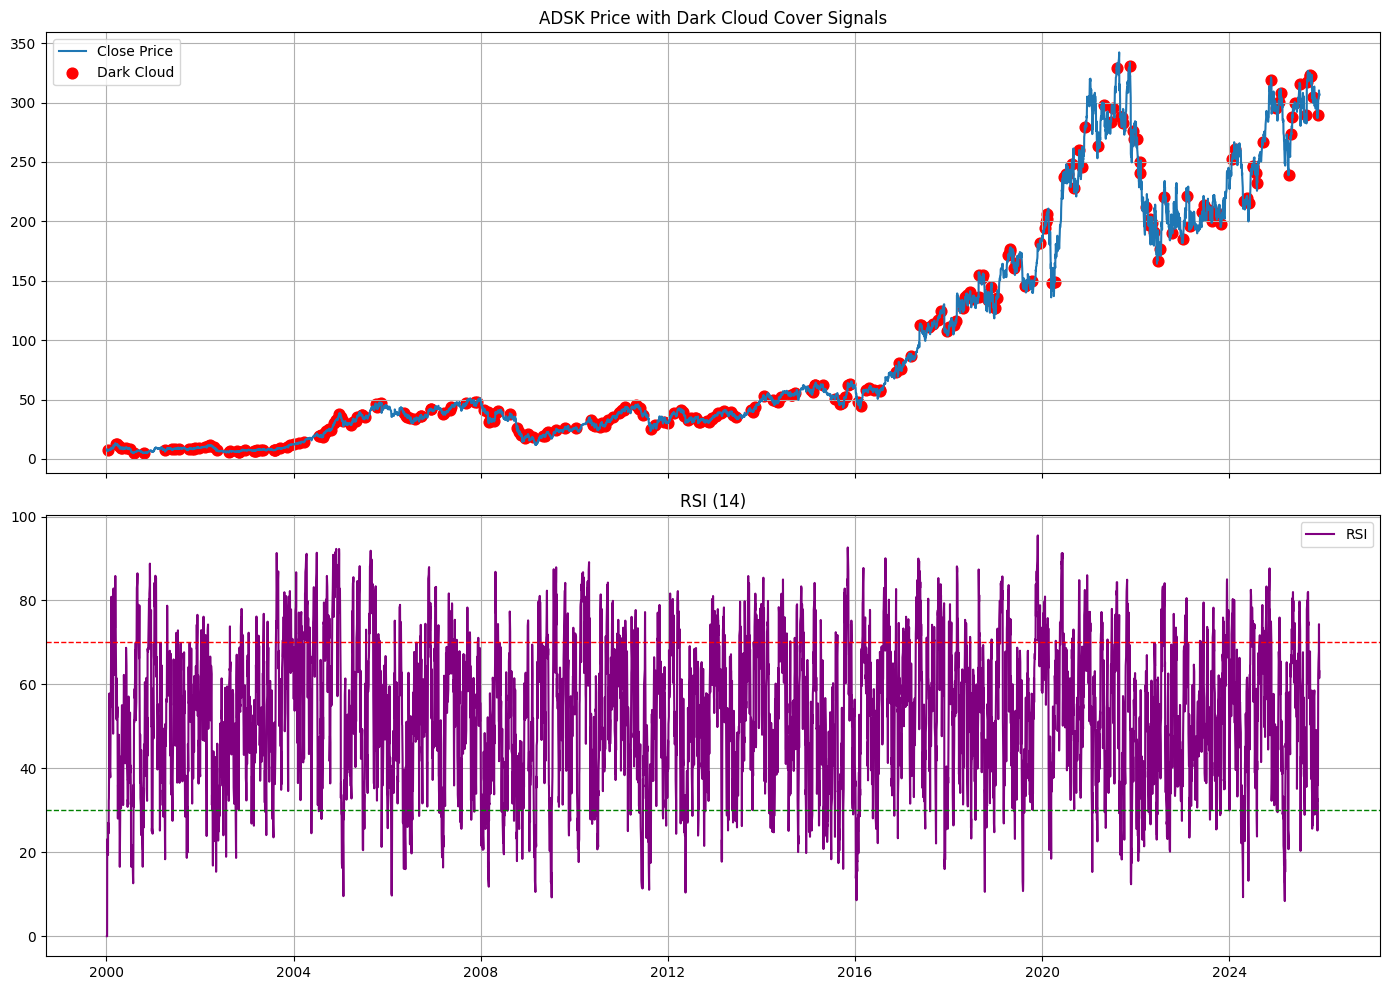

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------

symbol = "ADSK"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval)
df.dropna(inplace=True)

# -------------------------
# RSI Calculation
# -------------------------

def calculate_rsi(df, period=14):
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)

    roll_up = up.ewm(span=period, adjust=False).mean()
    roll_down = down.ewm(span=period, adjust=False).mean()

    rs = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

df = calculate_rsi(df)

# -------------------------
# Dark Cloud Cover Detection
# -------------------------

def dark_cloud(df):
    prev_close = df['Close'].shift(1)
    prev_open = df['Open'].shift(1)
    return (
        (prev_close > prev_open) &            # previous candle bullish
        (df['Open'] > prev_close) &           # gap up
        (df['Close'] < prev_close) &          # bearish close into previous body
        (df['Close'] > prev_open)             # but still above previous open
    )

df["Dark_Cloud"] = dark_cloud(df)

# -------------------------
# Plot Price + Dark Cloud + RSI
# -------------------------

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# ---- PRICE CHART ----
ax1.plot(df.index, df['Close'], label="Close Price")
ax1.set_title("ADSK Price with Dark Cloud Cover Signals")

# Mark Dark Cloud
dc_df = df[df["Dark_Cloud"] == True]
ax1.scatter(dc_df.index, dc_df['Close'], color='red', label="Dark Cloud", s=60)

ax1.legend()
ax1.grid(True)

# ---- RSI CHART ----
ax2.plot(df.index, df['RSI'], label="RSI", color='purple')
ax2.axhline(70, color='red', linestyle='--', linewidth=1)
ax2.axhline(30, color='green', linestyle='--', linewidth=1)

ax2.set_title("RSI (14)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
